In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [3]:
# raw data location
data_path = 'visapy_data.npy'

In [4]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [5]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


# Data Prepping and Split

In [6]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

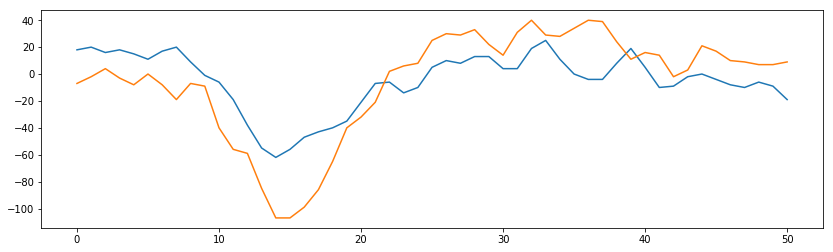

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [0, 1]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [131]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [132]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

# print(np.amin(electrode_data), np.amax(electrode_data))

In [133]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (26260, 51)
Test Datasize: (6566, 51)


# Helper Functions

In [149]:
def find_scaled_mse(original, recons, params):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.std(original[i, :])
        mse.append(np.mean(se))
    print(params, np.median(mse))
    mse = np.array(mse)
    return mse

In [135]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [136]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs):
    fig = plt.figure(1, figsize=(7,5))
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=False, notch=True)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.show()

In [137]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder

In [138]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [139]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])
    
    min_batch = 3
    
    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data.view(-1, min_batch, 1))
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        #enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

# DEFINING MODELS

In [140]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size, min_batch):
    losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for i, feats in enumerate(selected):
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x.view(-1, min_batch, 1))
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        if num_epoch%10 == 0:
            print('epoch [{}/{}], loss:{:.8f}, avg:{:.8f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple LSTM1 - LIN

In [141]:
class lstm_autoencoder3(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder3, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        hid = 2
        
        first_lin_size = hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hid, num_layers=1)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, 25)
        self.lin3 = nn.Linear(25, input_size)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.lin2(enc)
        out = self.activation_layer(out)
        dec = self.lin3(out)
        return enc, dec
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [142]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.00001
min_batch = 1

# embedding_size = 4

# ae_14 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_12 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12 = train_ae(ae_12, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
# np.save('models/lstm_models/losses_1_4', np.array(losses_14))
np.save('models/lstm_models/losses_1_2', np.array(losses_12))


# Saving Models
# torch.save(ae_14, 'models/lstm_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_12, 'models/lstm_models/ae_1_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 1647
epoch [1/5000], loss:893.18994141, avg:1274.34301758
epoch [11/5000], loss:2423.66479492, avg:1792.54614258
epoch [21/5000], loss:164.00164795, avg:1355.72412109
epoch [31/5000], loss:949.71868896, avg:983.09960938
epoch [41/5000], loss:262.73397827, avg:1070.63928223
epoch [51/5000], loss:3499.26757812, avg:1206.12731934
epoch [61/5000], loss:563.01190186, avg:1208.76733398
epoch [71/5000], loss:1280.59729004, avg:1103.95605469
epoch [81/5000], loss:974.30621338, avg:835.75994873
epoch [91/5000], loss:1635.03503418, avg:1036.74450684
epoch [101/5000], loss:326.11325073, avg:671.76965332
epoch [111/5000], loss:285.70364380, avg:668.18457031
epoch [121/5000], loss:487.52392578, avg:453.66232300
epoch [131/5000], loss:796.82055664, avg:401.66946411
epoch [141/5000], loss:1847.54919434, avg:612.20495605
epoch [151/5000], loss:638.19390869, avg:401.65158081
epoch [161/5000], loss:225.97927856, avg:411.10372925
epoch [171/5000], loss:477.76739502, avg:344.12

epoch [1511/5000], loss:80.37202454, avg:186.29545593
epoch [1521/5000], loss:228.96943665, avg:223.99812317
epoch [1531/5000], loss:90.77228546, avg:251.11726379
epoch [1541/5000], loss:128.35153198, avg:177.50065613
epoch [1551/5000], loss:252.92175293, avg:289.46615601
epoch [1561/5000], loss:48.33471680, avg:230.43762207
epoch [1571/5000], loss:445.46960449, avg:210.36820984
epoch [1581/5000], loss:190.69648743, avg:261.00042725
epoch [1591/5000], loss:178.50294495, avg:320.26278687
epoch [1601/5000], loss:919.14428711, avg:272.93130493
epoch [1611/5000], loss:52.86369324, avg:199.69371033
epoch [1621/5000], loss:122.20938873, avg:171.44848633
epoch [1631/5000], loss:717.41009521, avg:345.65133667
epoch [1641/5000], loss:74.26566315, avg:322.70123291
epoch [1651/5000], loss:135.92643738, avg:264.10681152
epoch [1661/5000], loss:269.42715454, avg:189.84544373
epoch [1671/5000], loss:313.44784546, avg:143.99096680
epoch [1681/5000], loss:234.25433350, avg:273.25653076
epoch [1691/500

epoch [3011/5000], loss:127.69158173, avg:250.45970154
epoch [3021/5000], loss:91.90808868, avg:303.36053467
epoch [3031/5000], loss:74.56604767, avg:187.56425476
epoch [3041/5000], loss:204.92712402, avg:205.41316223
epoch [3051/5000], loss:222.00332642, avg:203.21592712
epoch [3061/5000], loss:350.50387573, avg:264.50772095
epoch [3071/5000], loss:383.27056885, avg:214.57901001
epoch [3081/5000], loss:102.54739380, avg:339.16397095
epoch [3091/5000], loss:402.32705688, avg:165.61050415
epoch [3101/5000], loss:319.14886475, avg:202.32498169
epoch [3111/5000], loss:91.59649658, avg:229.13447571
epoch [3121/5000], loss:144.50698853, avg:207.74534607
epoch [3131/5000], loss:75.14700317, avg:134.57075500
epoch [3141/5000], loss:110.14118958, avg:224.64363098
epoch [3151/5000], loss:127.66031647, avg:209.96252441
epoch [3161/5000], loss:213.70303345, avg:364.88613892
epoch [3171/5000], loss:985.31640625, avg:322.62930298
epoch [3181/5000], loss:133.93644714, avg:249.74729919
epoch [3191/50

epoch [4521/5000], loss:144.90612793, avg:101.51295471
epoch [4531/5000], loss:149.89013672, avg:168.71072388
epoch [4541/5000], loss:103.11193085, avg:142.20867920
epoch [4551/5000], loss:63.44464111, avg:168.51098633
epoch [4561/5000], loss:60.36089325, avg:175.43725586
epoch [4571/5000], loss:96.96855164, avg:159.77964783
epoch [4581/5000], loss:347.07904053, avg:165.05725098
epoch [4591/5000], loss:132.70433044, avg:123.56617737
epoch [4601/5000], loss:78.02500153, avg:119.54711914
epoch [4611/5000], loss:94.79864502, avg:108.75599670
epoch [4621/5000], loss:80.06179810, avg:132.37916565
epoch [4631/5000], loss:124.50030518, avg:101.52935028
epoch [4641/5000], loss:315.22079468, avg:113.11054993
epoch [4651/5000], loss:108.15226746, avg:121.45037842
epoch [4661/5000], loss:39.24363327, avg:140.53445435
epoch [4671/5000], loss:74.62012482, avg:116.28533173
epoch [4681/5000], loss:158.98971558, avg:143.79496765
epoch [4691/5000], loss:784.65454102, avg:174.16377258
epoch [4701/5000],

In [143]:
ae_1 = torch.load('models/lstm_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

AE 0.9485074914854009
PCA 0.9483949747235512


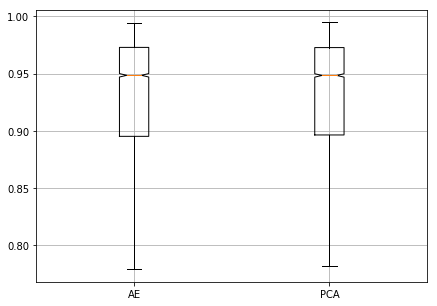

In [148]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.216543984640481
AE 3.285644343276635


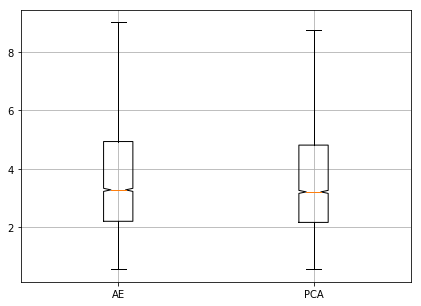

In [150]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# LSTM2- LIN

TOTAL PARAMETERS FOR MODEL: 1695
epoch [1/5000], loss:2642.03564453, avg:971.62054443
epoch [11/5000], loss:1525.94580078, avg:1002.11541748
epoch [21/5000], loss:1405.77770996, avg:1521.62341309
epoch [31/5000], loss:1802.89538574, avg:2060.91503906
epoch [41/5000], loss:1811.62561035, avg:1403.75329590
epoch [51/5000], loss:1597.09777832, avg:1979.01989746
epoch [61/5000], loss:1297.00061035, avg:1341.94519043
epoch [71/5000], loss:2035.09411621, avg:1253.28759766
epoch [81/5000], loss:761.19299316, avg:911.73358154
epoch [91/5000], loss:167.67864990, avg:823.70422363
epoch [101/5000], loss:843.23443604, avg:671.97180176
epoch [111/5000], loss:608.28637695, avg:498.94931030
epoch [121/5000], loss:342.39828491, avg:481.28839111
epoch [131/5000], loss:305.79614258, avg:423.89306641
epoch [141/5000], loss:214.94331360, avg:227.91653442
epoch [151/5000], loss:319.56295776, avg:356.78555298
epoch [161/5000], loss:187.53358459, avg:317.94030762
epoch [171/5000], loss:298.96475220, avg:288.

epoch [1511/5000], loss:179.64198303, avg:167.13038635
epoch [1521/5000], loss:203.02972412, avg:282.42062378
epoch [1531/5000], loss:630.34484863, avg:308.38409424
epoch [1541/5000], loss:137.73925781, avg:420.28573608
epoch [1551/5000], loss:594.76202393, avg:235.04649353
epoch [1561/5000], loss:116.19279480, avg:216.71426392
epoch [1571/5000], loss:150.94177246, avg:270.68991089
epoch [1581/5000], loss:229.18479919, avg:184.37791443
epoch [1591/5000], loss:48.69954300, avg:302.58505249
epoch [1601/5000], loss:107.11391449, avg:227.33100891
epoch [1611/5000], loss:155.11279297, avg:238.86514282
epoch [1621/5000], loss:270.17999268, avg:268.91622925
epoch [1631/5000], loss:189.17718506, avg:293.21762085
epoch [1641/5000], loss:139.64033508, avg:200.30940247
epoch [1651/5000], loss:280.85815430, avg:274.89163208
epoch [1661/5000], loss:172.16209412, avg:264.41265869
epoch [1671/5000], loss:405.18203735, avg:278.25738525
epoch [1681/5000], loss:169.42617798, avg:237.30528259
epoch [1691

epoch [3011/5000], loss:272.57458496, avg:290.83609009
epoch [3021/5000], loss:88.88216400, avg:247.43644714
epoch [3031/5000], loss:186.64955139, avg:178.24540710
epoch [3041/5000], loss:170.56288147, avg:239.00588989
epoch [3051/5000], loss:287.85577393, avg:261.30496216
epoch [3061/5000], loss:422.65072632, avg:307.78823853
epoch [3071/5000], loss:70.88672638, avg:161.16213989
epoch [3081/5000], loss:127.80415344, avg:263.89230347
epoch [3091/5000], loss:94.12537384, avg:313.04785156
epoch [3101/5000], loss:115.69480133, avg:222.51174927
epoch [3111/5000], loss:101.21109009, avg:324.50323486
epoch [3121/5000], loss:98.62574768, avg:288.28341675
epoch [3131/5000], loss:315.04394531, avg:226.76402283
epoch [3141/5000], loss:309.99716187, avg:213.89541626
epoch [3151/5000], loss:290.64990234, avg:225.65049744
epoch [3161/5000], loss:130.43597412, avg:155.24807739
epoch [3171/5000], loss:170.02380371, avg:214.84895325
epoch [3181/5000], loss:233.31481934, avg:152.81584167
epoch [3191/50

epoch [4511/5000], loss:245.23132324, avg:177.67562866
epoch [4521/5000], loss:109.91680145, avg:178.06748962
epoch [4531/5000], loss:194.76696777, avg:167.83128357
epoch [4541/5000], loss:66.55754089, avg:153.99545288
epoch [4551/5000], loss:121.66951752, avg:116.88433838
epoch [4561/5000], loss:121.35775757, avg:217.88938904
epoch [4571/5000], loss:862.21215820, avg:388.96478271
epoch [4581/5000], loss:266.87557983, avg:210.96958923
epoch [4591/5000], loss:115.15602875, avg:348.01547241
epoch [4601/5000], loss:235.51957703, avg:226.39790344
epoch [4611/5000], loss:156.66813660, avg:184.50762939
epoch [4621/5000], loss:244.71409607, avg:211.44490051
epoch [4631/5000], loss:126.99627686, avg:150.41255188
epoch [4641/5000], loss:146.55499268, avg:191.70378113
epoch [4651/5000], loss:69.34732056, avg:187.10769653
epoch [4661/5000], loss:390.65402222, avg:205.46406555
epoch [4671/5000], loss:53.43000412, avg:164.23741150
epoch [4681/5000], loss:172.35476685, avg:190.70405579
epoch [4691/5

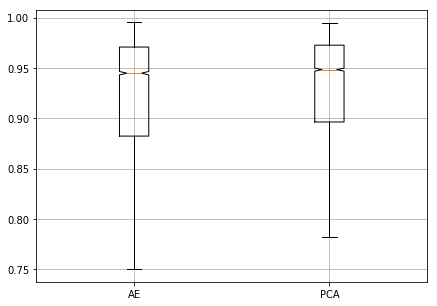

PCA 3.2165439846405297
AE 7.006110100226291


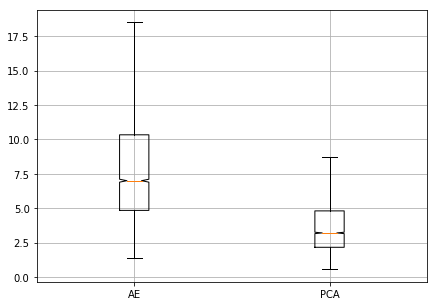

In [151]:
class lstm_autoencoder4(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder4, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        hid = 2
        
        first_lin_size = hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hid, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, 25)
        self.lin3 = nn.Linear(25, input_size)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.lin2(enc)
        out = self.activation_layer(out)
        dec = self.lin3(out)
        return enc, dec
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.00001
min_batch = 1

# embedding_size = 4

# ae_14 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_01 = lstm_autoencoder4(length, min_batch, embedding_size).cuda()
ae_01.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_01.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_01 = train_ae(ae_01, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
# np.save('models/lstm_models/losses_1_4', np.array(losses_14))
np.save('models/lstm_models/losses_2_2', np.array(losses_01))


# Saving Models
# torch.save(ae_14, 'models/lstm_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_01, 'models/lstm_models/ae_2_2.pt') #Saving the autoencoder model

ae_1 = torch.load('models/lstm_models/ae_2_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Simple LSTM2 - LSTM2

In [152]:
class lstm_autoencoder2(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder2, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        self.hid = 2
        self.batch_size = batch_size
        
        first_lin_size = self.hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hid, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lstm2 = nn.LSTM(input_size=self.hid, hidden_size=1, num_layers=2)
        
        self.lin3 = nn.Linear(51, 51)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.activation_layer(enc)
        out = self.lin2(out)
        out = self.activation_layer(out)
        out = self.serialise_input_dec(out)
        out, _ = self.lstm2(out)
        out = self.flatten_input(out)
        dec = self.lin3(out)
        return enc, dec

    
    def serialise_input_dec(self, data):
        data = data.view(-1, self.batch_size, self.hid)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [153]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.0001
min_batch = 1

# embedding_size = 4

# ae_44 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_42 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42 = train_ae(ae_42, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
#np.save('models/lstm_models/losses_4_4', np.array(losses_44))
np.save('models/lstm_models/losses_4_2', np.array(losses_42))


# Saving Models
#torch.save(ae_44, 'models/lstm_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_42, 'models/lstm_models/ae_4_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 3288
epoch [1/5000], loss:2005.89916992, avg:1955.98205566
epoch [11/5000], loss:1728.65551758, avg:1379.51379395
epoch [21/5000], loss:576.24591064, avg:675.49804688
epoch [31/5000], loss:382.37844849, avg:632.86907959
epoch [41/5000], loss:310.15536499, avg:630.49853516
epoch [51/5000], loss:1235.68640137, avg:501.03921509
epoch [61/5000], loss:289.71618652, avg:378.12277222
epoch [71/5000], loss:817.36712646, avg:363.53244019
epoch [81/5000], loss:76.58873749, avg:231.20588684
epoch [91/5000], loss:1273.95275879, avg:537.07159424
epoch [101/5000], loss:199.04551697, avg:252.22724915
epoch [111/5000], loss:202.29846191, avg:316.89694214
epoch [121/5000], loss:207.17137146, avg:300.68734741
epoch [131/5000], loss:253.96058655, avg:210.52903748
epoch [141/5000], loss:317.67355347, avg:278.79339600
epoch [151/5000], loss:131.58854675, avg:269.59713745
epoch [161/5000], loss:141.66535950, avg:203.50196838
epoch [171/5000], loss:243.74903870, avg:165.35856628
e

epoch [1521/5000], loss:88.12526703, avg:119.95998383
epoch [1531/5000], loss:157.30995178, avg:152.22816467
epoch [1541/5000], loss:142.18673706, avg:176.14372253
epoch [1551/5000], loss:468.60293579, avg:168.74131775
epoch [1561/5000], loss:81.69306946, avg:175.46981812
epoch [1571/5000], loss:98.69318390, avg:101.70960236
epoch [1581/5000], loss:180.98188782, avg:181.90489197
epoch [1591/5000], loss:78.80900574, avg:124.53025055
epoch [1601/5000], loss:110.54840851, avg:127.80352020
epoch [1611/5000], loss:128.91773987, avg:187.52688599
epoch [1621/5000], loss:88.35341644, avg:145.82766724
epoch [1631/5000], loss:466.93450928, avg:141.79634094
epoch [1641/5000], loss:97.95270538, avg:156.29176331
epoch [1651/5000], loss:129.44747925, avg:145.15408325
epoch [1661/5000], loss:116.19239044, avg:108.67089844
epoch [1671/5000], loss:210.54048157, avg:127.63138580
epoch [1681/5000], loss:246.59489441, avg:146.77293396
epoch [1691/5000], loss:718.97845459, avg:258.90576172
epoch [1701/5000

epoch [3031/5000], loss:136.33174133, avg:91.40102386
epoch [3041/5000], loss:169.37411499, avg:100.97362518
epoch [3051/5000], loss:144.42771912, avg:114.91638184
epoch [3061/5000], loss:205.49566650, avg:143.58169556
epoch [3071/5000], loss:37.90996933, avg:90.99830627
epoch [3081/5000], loss:160.37373352, avg:146.77148438
epoch [3091/5000], loss:159.21929932, avg:196.60144043
epoch [3101/5000], loss:102.94213104, avg:186.27545166
epoch [3111/5000], loss:58.66134262, avg:156.63969421
epoch [3121/5000], loss:116.46575928, avg:132.57127380
epoch [3131/5000], loss:270.24447632, avg:107.39780426
epoch [3141/5000], loss:141.16383362, avg:112.39066315
epoch [3151/5000], loss:143.93298340, avg:133.50740051
epoch [3161/5000], loss:56.45091248, avg:105.33231354
epoch [3171/5000], loss:61.25897598, avg:99.91445160
epoch [3181/5000], loss:125.21942139, avg:267.98233032
epoch [3191/5000], loss:59.92678833, avg:136.29542542
epoch [3201/5000], loss:260.17065430, avg:131.42552185
epoch [3211/5000],

epoch [4541/5000], loss:86.30355835, avg:108.23323059
epoch [4551/5000], loss:72.30204773, avg:144.87538147
epoch [4561/5000], loss:68.56136322, avg:101.38094330
epoch [4571/5000], loss:97.66058350, avg:112.68074036
epoch [4581/5000], loss:299.88360596, avg:118.85970306
epoch [4591/5000], loss:151.23123169, avg:110.64249420
epoch [4601/5000], loss:908.80187988, avg:193.46131897
epoch [4611/5000], loss:90.26447296, avg:123.04483795
epoch [4621/5000], loss:86.27408600, avg:261.43295288
epoch [4631/5000], loss:65.38750458, avg:118.85102844
epoch [4641/5000], loss:56.63859558, avg:103.91692352
epoch [4651/5000], loss:103.93836212, avg:185.94459534
epoch [4661/5000], loss:199.23800659, avg:173.56700134
epoch [4671/5000], loss:33.76086044, avg:158.95777893
epoch [4681/5000], loss:47.14266968, avg:90.82258606
epoch [4691/5000], loss:226.83058167, avg:146.59709167
epoch [4701/5000], loss:186.58894348, avg:114.27021790
epoch [4711/5000], loss:40.63241959, avg:218.74267578
epoch [4721/5000], los

In [154]:
ae_1 = torch.load('models/lstm_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

AE 0.9475924537980092
PCA 0.9483949747235509


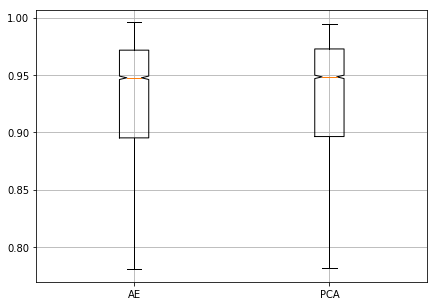

In [155]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2165439846404675
AE 4.56176007666524


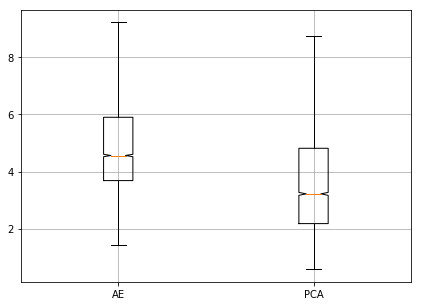

In [156]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# LSTM1 - LSTM1

TOTAL PARAMETERS FOR MODEL: 3224
epoch [1/5000], loss:2023.62072754, avg:1721.22937012
epoch [11/5000], loss:746.51171875, avg:914.66320801
epoch [21/5000], loss:1785.05456543, avg:774.29388428
epoch [31/5000], loss:462.12670898, avg:614.77734375
epoch [41/5000], loss:157.87408447, avg:372.89675903
epoch [51/5000], loss:153.55537415, avg:375.85998535
epoch [61/5000], loss:513.06585693, avg:489.66671753
epoch [71/5000], loss:284.03543091, avg:267.82077026
epoch [81/5000], loss:445.33728027, avg:256.48263550
epoch [91/5000], loss:345.71655273, avg:519.37420654
epoch [101/5000], loss:303.77203369, avg:243.89973450
epoch [111/5000], loss:185.83059692, avg:305.22473145
epoch [121/5000], loss:168.68481445, avg:190.04150391
epoch [131/5000], loss:166.16065979, avg:256.97872925
epoch [141/5000], loss:307.77130127, avg:200.47618103
epoch [151/5000], loss:530.04608154, avg:269.27774048
epoch [161/5000], loss:100.61509705, avg:295.85134888
epoch [171/5000], loss:262.36819458, avg:214.67393494
epo

epoch [1521/5000], loss:221.32766724, avg:148.76290894
epoch [1531/5000], loss:184.00044250, avg:119.26515198
epoch [1541/5000], loss:84.55965424, avg:123.68038177
epoch [1551/5000], loss:89.75173950, avg:101.35932922
epoch [1561/5000], loss:86.72351837, avg:140.49330139
epoch [1571/5000], loss:707.55810547, avg:205.69038391
epoch [1581/5000], loss:43.50484848, avg:113.62426758
epoch [1591/5000], loss:517.90783691, avg:342.74966431
epoch [1601/5000], loss:197.33180237, avg:136.20539856
epoch [1611/5000], loss:54.46187592, avg:142.06127930
epoch [1621/5000], loss:92.18939209, avg:98.67896271
epoch [1631/5000], loss:67.20311737, avg:133.78570557
epoch [1641/5000], loss:90.59285736, avg:127.22324371
epoch [1651/5000], loss:46.10995102, avg:94.38598633
epoch [1661/5000], loss:73.16101074, avg:146.73275757
epoch [1671/5000], loss:106.18964386, avg:97.02627563
epoch [1681/5000], loss:100.19438171, avg:95.95026398
epoch [1691/5000], loss:204.13476562, avg:128.60696411
epoch [1701/5000], loss:

epoch [3031/5000], loss:96.30509186, avg:93.01248169
epoch [3041/5000], loss:219.14248657, avg:162.33053589
epoch [3051/5000], loss:113.42040253, avg:82.57253265
epoch [3061/5000], loss:49.92172241, avg:122.88990784
epoch [3071/5000], loss:66.15569305, avg:85.12735748
epoch [3081/5000], loss:91.45413208, avg:161.16931152
epoch [3091/5000], loss:91.95211029, avg:103.58780670
epoch [3101/5000], loss:39.48046875, avg:139.14743042
epoch [3111/5000], loss:111.00160980, avg:119.44901276
epoch [3121/5000], loss:156.34005737, avg:141.26112366
epoch [3131/5000], loss:88.06745911, avg:133.74327087
epoch [3141/5000], loss:144.56819153, avg:121.73921967
epoch [3151/5000], loss:67.31558990, avg:127.08843231
epoch [3161/5000], loss:220.70312500, avg:117.64481354
epoch [3171/5000], loss:91.55359650, avg:79.31377411
epoch [3181/5000], loss:537.55682373, avg:141.34060669
epoch [3191/5000], loss:146.99163818, avg:120.04196930
epoch [3201/5000], loss:93.55493927, avg:132.08480835
epoch [3211/5000], loss:

epoch [4541/5000], loss:220.82803345, avg:167.79663086
epoch [4551/5000], loss:185.85681152, avg:119.44243622
epoch [4561/5000], loss:215.73353577, avg:135.96055603
epoch [4571/5000], loss:63.24258423, avg:138.51695251
epoch [4581/5000], loss:159.39469910, avg:131.75500488
epoch [4591/5000], loss:62.74751663, avg:153.62419128
epoch [4601/5000], loss:67.43146515, avg:108.24098969
epoch [4611/5000], loss:177.10112000, avg:131.21705627
epoch [4621/5000], loss:96.48150635, avg:148.34175110
epoch [4631/5000], loss:109.10921478, avg:142.72518921
epoch [4641/5000], loss:86.02996063, avg:149.22958374
epoch [4651/5000], loss:98.75049591, avg:123.93735504
epoch [4661/5000], loss:72.53766632, avg:135.79992676
epoch [4671/5000], loss:116.26047516, avg:111.84840393
epoch [4681/5000], loss:72.85446167, avg:110.36653137
epoch [4691/5000], loss:76.35489655, avg:167.93750000
epoch [4701/5000], loss:148.75073242, avg:100.88976288
epoch [4711/5000], loss:102.79965973, avg:114.50601959
epoch [4721/5000], 

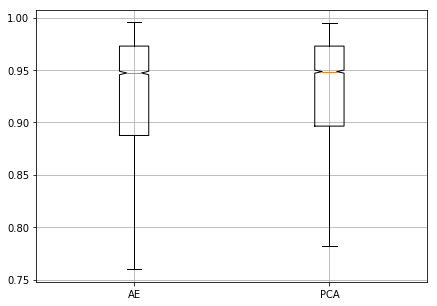

PCA 3.216543984640462
AE 4.818538181123671


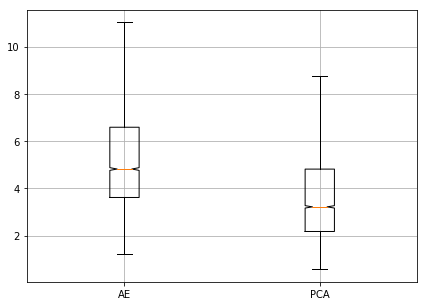

In [157]:
class lstm_autoencoder0(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder0, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        self.hid = 2
        self.batch_size = batch_size
        
        first_lin_size = self.hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hid, num_layers=1)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lstm2 = nn.LSTM(input_size=self.hid, hidden_size=1, num_layers=1)
        
        self.lin3 = nn.Linear(51, 51)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.activation_layer(enc)
        out = self.lin2(out)
        out = self.activation_layer(out)
        out = self.serialise_input_dec(out)
        out, _ = self.lstm2(out)
        out = self.flatten_input(out)
        dec = self.lin3(out)
        return enc, dec

    
    def serialise_input_dec(self, data):
        data = data.view(-1, self.batch_size, self.hid)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.0001
min_batch = 1

# embedding_size = 4

# ae_44 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_02 = lstm_autoencoder0(length, min_batch, embedding_size).cuda()
ae_02.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_02.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_02 = train_ae(ae_02, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
#np.save('models/lstm_models/losses_4_4', np.array(losses_44))
np.save('models/lstm_models/losses_11_2', np.array(losses_02))


# Saving Models
#torch.save(ae_44, 'models/lstm_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_02, 'models/lstm_models/ae_11_2.pt') #Saving the autoencoder model

ae_1 = torch.load('models/lstm_models/ae_11_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

In [ ]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse, 'Baseline': baseline})

In [ ]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [ ]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

print(meds)
relative_improvement(meds[0][1], meds[1][1], meds[2][1])

In [ ]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

In [ ]:
inputs = electrode_data_test[0, :]
inputs = torch.from_numpy(inputs).float()
batch_size = 3
inputs = inputs.view(-1, batch_size, 1)
print(inputs.shape)